# Dogs vs. Cats Classification

### data set link : https://www.kaggle.com/c/dogs-vs-cats/data

### importing libraries

In [29]:
import numpy as np
import seaborn as sns
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os



### image properties:

In [30]:
FAST_RUN = False
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [31]:
print(os.listdir('../'))

['Digit Recogizer', 'dogs-vs-cats', 'model1_catsVSdogs_10epoch.h5']


### Preparing data for training Model                               

In [32]:
filenames = os.listdir("../dogs-vs-cats/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [33]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [34]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


### Counting the dog or cat images on training  set.

In [35]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

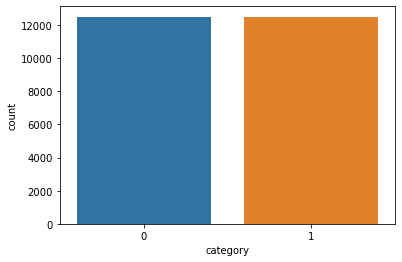

In [36]:

sns.countplot(df['category'])

- we have 12500 dogs images and 12500 cats images in train dataset.


### Checking the random image from  train dataset

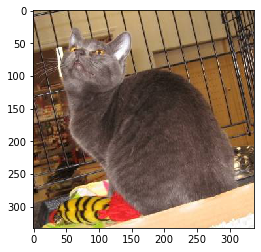

In [37]:
sample = random.choice(filenames)
image = load_img("../dogs-vs-cats/train/train/"+sample)
plt.imshow(image)

## Building a Model

- Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
- Conv Layer: This layer will extract features from image.

- Pooling Layer: This layerreduce the spatial volume of input image after convolution.

- Fully Connected Layer: It connect the network from a layer to another layer
- Output Layer: It is the predicted values layer.


In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())                   
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

### Callbacks

In [40]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early Stop

- To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [41]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction

- We will reduce the learning rate when then accuracy not increase for 2 steps

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [43]:
callbacks = [earlystop, learning_rate_reduction]

# Data prepration 

In [44]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [45]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


In [46]:
train_df

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10915.jpg,cat
3,dog.10127.jpg,dog
4,cat.11377.jpg,cat
...,...,...
19995,dog.6916.jpg,dog
19996,cat.36.jpg,cat
19997,cat.10771.jpg,cat
19998,dog.1713.jpg,dog


In [47]:
validate_df

,filename,category
0,cat.493.jpg,cat
1,dog.9112.jpg,dog
2,cat.745.jpg,cat
3,dog.11022.jpg,dog
4,dog.11363.jpg,dog
...,...,...
4995,cat.6551.jpg,cat
4996,cat.9403.jpg,cat
4997,cat.236.jpg,cat
4998,dog.6530.jpg,dog


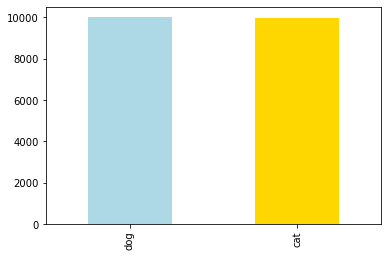

In [48]:

train_df['category'].value_counts().plot.bar(color = ['lightblue', 'gold'])


- in training set  we have 10k image for dog or 10k  image for cat.

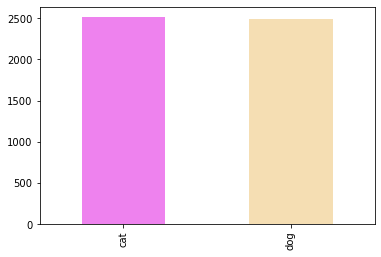

In [49]:
validate_df['category'].value_counts().plot.bar(color = ['violet', 'wheat'])

- In validation set we have 2500 image for dog or 2500 image for cat

In [50]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

# train Generator

In [51]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../dogs-vs-cats/train/train/", 
    x_col = 'filename',
    y_col = 'category',
    target_size = Image_Size,
    class_mode = 'categorical',  # cause label is string cat or dog if 0 or 1 then binary.
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


# validate Generator

In [52]:
validation_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)


Found 5000 validated image filenames belonging to 2 classes.


### let see how our generator work

In [53]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical'
)


Found 1 validated image filenames belonging to 1 classes.


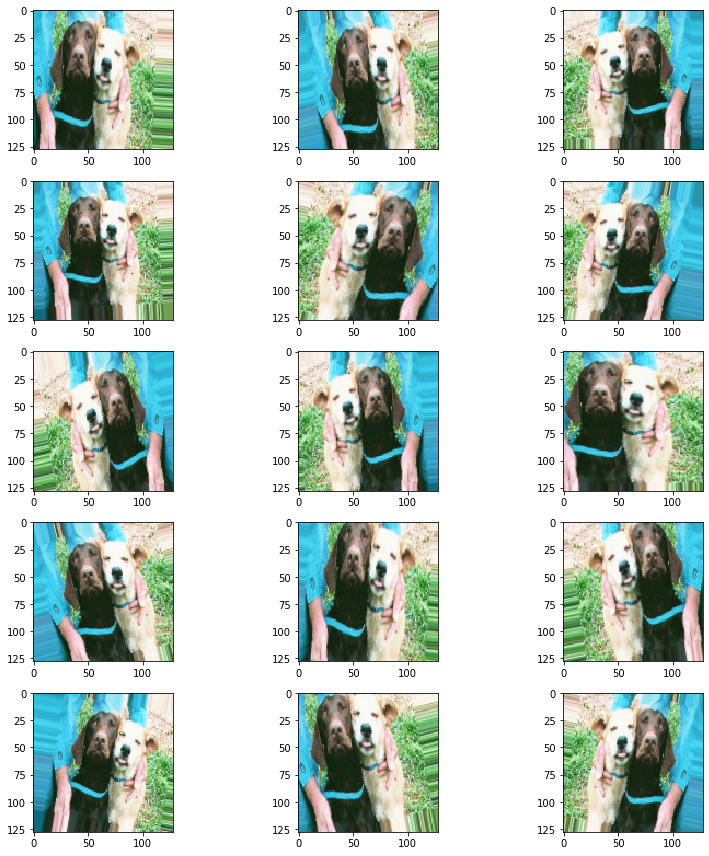

In [54]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fitting model

In [56]:
epochs= 3  if FAST_RUN else 10

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 859s 644ms/step - loss: 0.6900 - accuracy: 0.6513 - val_loss: 0.6265 - val_accuracy: 0.6653
Epoch 2/10
1333/1333 [==============================] - 852s 639ms/step - loss: 0.5436 - accuracy: 0.7316 - val_loss: 0.4158 - val_accuracy: 0.7675
Epoch 3/10
1333/1333 [==============================] - 861s 646ms/step - loss: 0.4901 - accuracy: 0.7726 - val_loss: 0.5986 - val_accuracy: 0.7426
Epoch 4/10
1333/1333 [==============================] - 3905s 3s/step - loss: 0.4495 - accuracy: 0.7963 - val_loss: 0.5592 - val_accuracy: 0.8114
Epoch 5/10
1333/1333 [==============================] - 2640s 2s/step - loss: 0.4307 - accuracy: 0.8077 - val_loss: 0.1982 - val_accuracy: 0.8349
Epoch 6/10
1333/1333 [==============================] - 1188s 892ms/step - loss: 0.4115 - accuracy: 0.8152 - val_loss: 0.3228 - val_accuracy: 0.8118
Epoch 7/10
1333/1333 [==============================] - 4686s 4s/step - loss: 0.3908 - accuracy: 0.8308 - val_loss:

### save the model

In [57]:
model.save("model1_catsVSdogs_10epoch.h5")

### Visualize the CNN Performance:

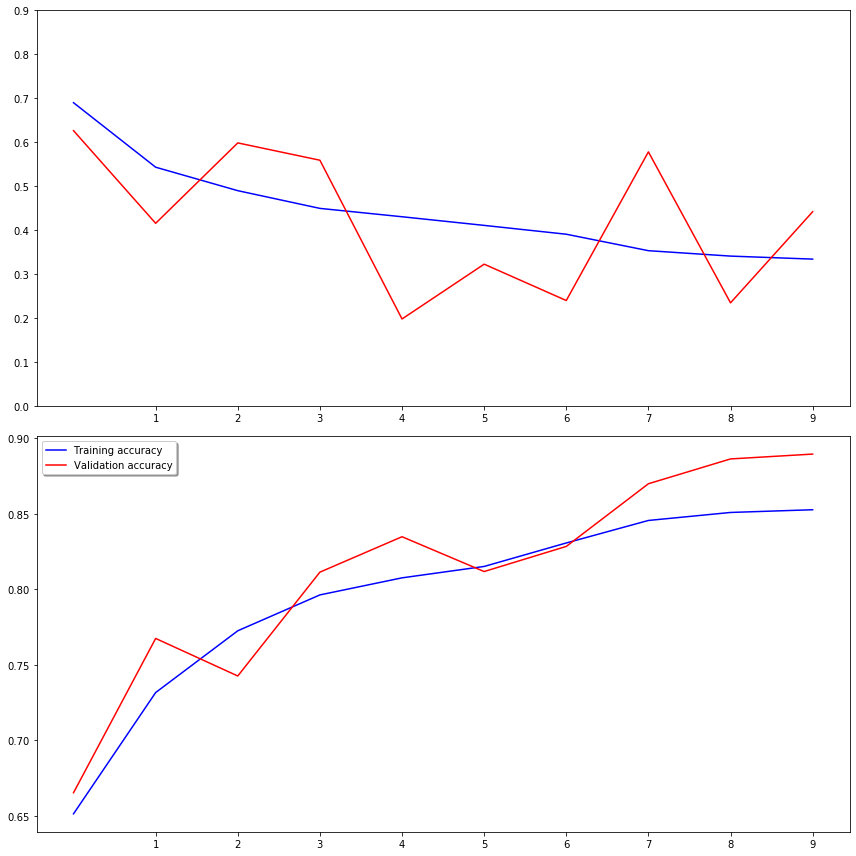

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Test data preparation:

In [59]:
test_filenames = os.listdir("../dogs-vs-cats/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### Creating Test Generator

In [60]:
test_gen = ImageDataGenerator(rescale=1./255)


test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../dogs-vs-cats/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=Image_Size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


### Predict the test set

In [61]:

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

- For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [62]:
test_df['category'] = np.argmax(predict, axis=-1)

- We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [63]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

- From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [64]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

##### visualize the result

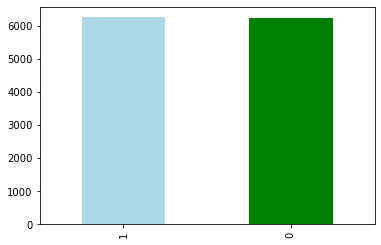

In [69]:
test_df['category'].value_counts().plot.bar(color = ['lightblue', 'green'])

### predicted result with images

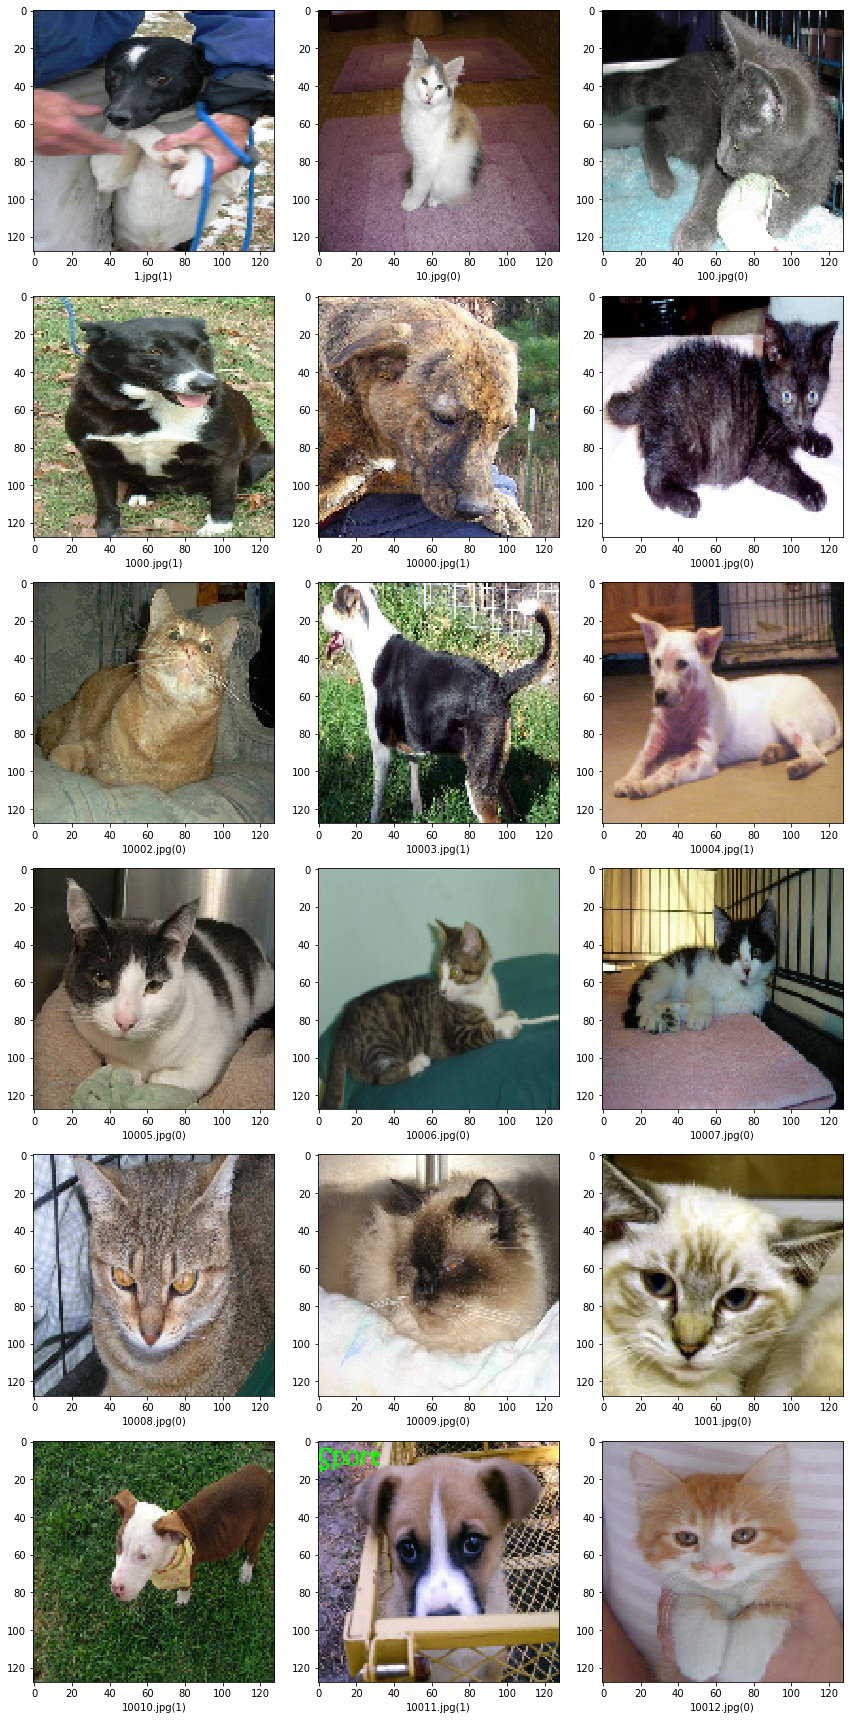

In [66]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../dogs-vs-cats/test1/test1/"+filename, target_size = Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()